In [1]:
! pip install empyrical

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from scipy.stats import invweibull
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from empyrical.stats import conditional_value_at_risk
import datetime

## Changed the inputting of data

In [24]:
# load the data

#pd.set_option('display.max_rows', None)

#rate_df = pd.read_csv("C:/Users/severusbot/Documents/AMS_517/Frechet_Model/EUR_USD_Historical_Data.csv")
rate_df=pd.read_csv('EUR_USD.csv')
rate_df = rate_df[['Date', 'Open', 'Price']]
rate_df['Date'] = pd.to_datetime(rate_df['Date'])
rate_df['return'] =100*(rate_df['Price']-rate_df['Open'])/rate_df['Open'] # set returns
rate_df = rate_df[['Date', 'return']]

# find the max loss of each week

rate_df.set_index('Date', inplace = True)

maxloss_df = -rate_df.resample('W').min().dropna() # - min return is max loss 
maxloss_df=maxloss_df.rename(columns={'return':'Loss'})

maxloss_df


,Loss
Date,
2012-03-11,1.257435
2012-03-18,0.501901
2012-03-25,0.105748
2012-04-01,0.269582
2012-04-08,0.680169
...,...
2022-03-13,0.922122
2022-03-20,0.324588
2022-03-27,0.406908


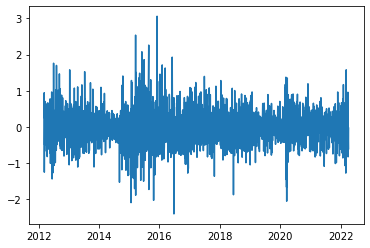

In [25]:
plt.plot(rate_df['return'])

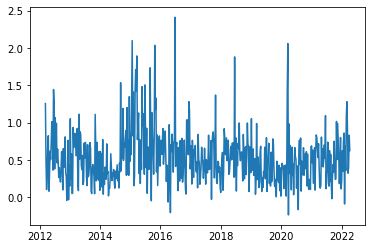

In [26]:
plt.plot(maxloss_df['Loss'])

In [27]:
# fit the frechet distribution using 500 data points

global_shape,global_loc,global_scale=invweibull.fit(maxloss_df['Loss'][:500])
global_shape,global_loc,global_scale


/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


(257.10807010448696, -71.02854919427088, 71.39563237985593)

No handles with labels found to put in legend.


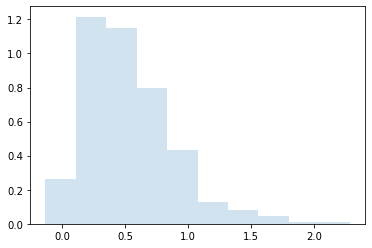

In [28]:
r = invweibull.rvs(global_shape,loc=global_loc,scale=global_scale, size=1000)
plt.hist(r, density=True, histtype='stepfilled', alpha=0.2)
plt.legend(loc='best', frameon=False)
plt.show()

(array([0.10033386, 0.895838  , 1.20400627, 1.00333856, 0.32966838,
        0.12183397, 0.06450034, 0.02150011, 0.02866682, 0.0071667 ]),
 array([-0.23373224,  0.03103846,  0.29580915,  0.56057985,  0.82535055,
         1.09012124,  1.35489194,  1.61966263,  1.88443333,  2.14920402,
         2.41397472]),
 <a list of 1 Patch objects>)

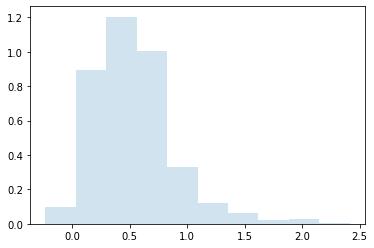

In [30]:
plt.hist(maxloss_df['Loss'], density=True, histtype='stepfilled', alpha=0.2)

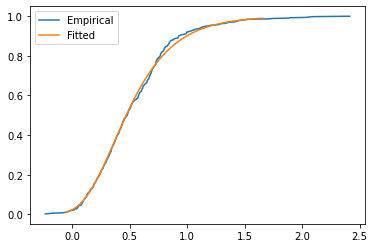

In [31]:
### Comparing Static distributions

ecdf=ECDF(maxloss_df['Loss'])
plt.plot(ecdf.x,ecdf.y,label='Empirical')

n=100
x = np.linspace(invweibull.ppf(0.01, global_shape,loc=global_loc,scale=global_scale),
                invweibull.ppf(0.99, global_shape,loc=global_loc,scale=global_scale), n)
frechet_cdf=invweibull.cdf(x,global_shape,loc=global_loc,scale=global_scale)
plt.plot(x,frechet_cdf,label='Fitted')
plt.legend()

In [32]:
# Time varying parameters

In [33]:
# we will use 250 samples

time_df = maxloss_df.copy()
time_df['Scale'] = np.nan
time_df['Shape'] = np.nan
time_df['Location'] = global_loc

def fit_invweibull(val):

    shape, loc, scale = invweibull.fit(val, floc = global_loc)
    return shape, loc, scale

for x in range(1, 251):
    time_df.iloc[250+x, 2], loc, time_df.iloc[250+x, 1] = fit_invweibull(maxloss_df['Loss'][:250+x])

time_df = time_df.bfill(axis = 'rows')
time_df = time_df.reset_index()

time_df

/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


,Date,Loss,Scale,Shape,Location
0,2012-03-11,1.257435,71.432007,228.756956,-71.028549
1,2012-03-18,0.501901,71.432007,228.756956,-71.028549
2,2012-03-25,0.105748,71.432007,228.756956,-71.028549
3,2012-04-01,0.269582,71.432007,228.756956,-71.028549
4,2012-04-08,0.680169,71.432007,228.756956,-71.028549
...,...,...,...,...,...
522,2022-03-13,0.922122,NaN,NaN,-71.028549
523,2022-03-20,0.324588,NaN,NaN,-71.028549
524,2022-03-27,0.406908,NaN,NaN,-71.028549
525,2022-04-03,0.833483,NaN,NaN,-71.028549


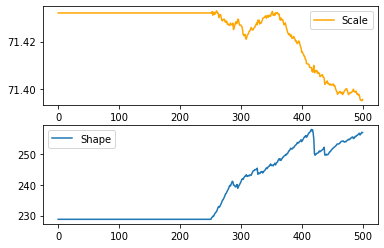

In [34]:
fig,ax = plt.subplots(2,1)

ax[1].plot(time_df['Shape'].values, label='Shape')
ax[0].plot(time_df['Scale'].values, label='Scale',color='orange') # flip returns to view
ax[0].legend()
ax[1].legend()

In [35]:
# estimating coefficients using the training set
temp_df = time_df.copy()
temp_df = temp_df.dropna()

exog = -temp_df['Loss'][249:-1].values

mod = AutoReg(np.log(temp_df['Shape'][250:].values), 1, trend = 'c', exog = np.exp(exog))
res = mod.fit()
shape_params = res.params
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  251
Model:                   AutoReg-X(1)   Log Likelihood                1206.714
Method:               Conditional MLE   S.D. of innovations              0.002
Date:                Thu, 14 Apr 2022   AIC                            -12.460
Time:                        14:32:09   BIC                            -12.403
Sample:                             1   HQIC                           -12.437
                                  251                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0731      0.023      3.234      0.001       0.029       0.117
y.L1           0.9867      0.004    239.831      0.000       0.979       0.995
x1             0.0009      0.001      1.220      0.2

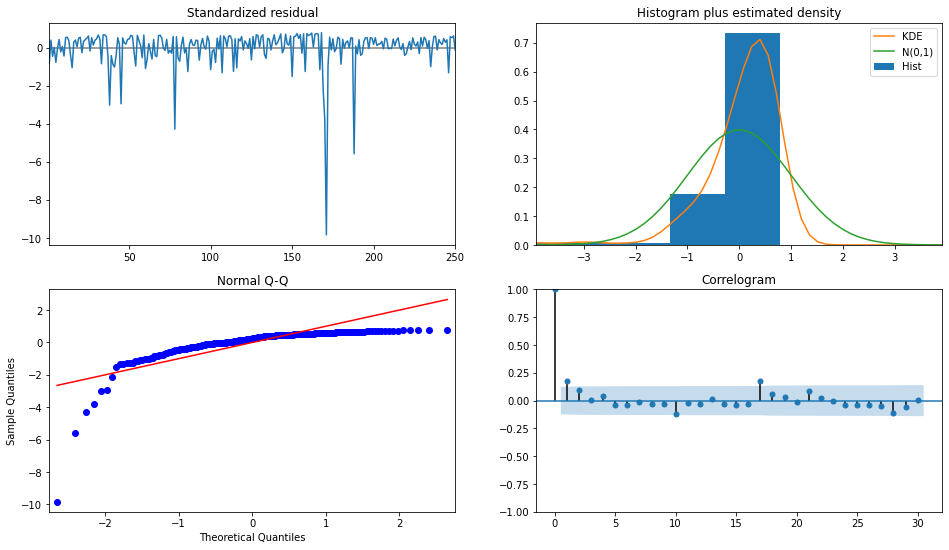

In [36]:
fig = plt.figure(figsize = (16, 9))
fig = res.plot_diagnostics(fig = fig, lags = 30)

In [37]:
exog = -temp_df['Loss'][224:-1].values

mod = AutoReg(np.log(temp_df['Scale'][225:].values), 1, trend = 'c', exog = np.exp(exog))
res = mod.fit()
scale_params = res.params
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  276
Model:                   AutoReg-X(1)   Log Likelihood                3036.217
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Thu, 14 Apr 2022   AIC                            -24.890
Time:                        14:32:10   BIC                            -24.838
Sample:                             1   HQIC                           -24.869
                                  276                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0144      0.006      2.565      0.010       0.003       0.025
y.L1           0.9966      0.001    755.661      0.000       0.994       0.999
x1         -5.431e-05   1.37e-06    -39.740      0.0

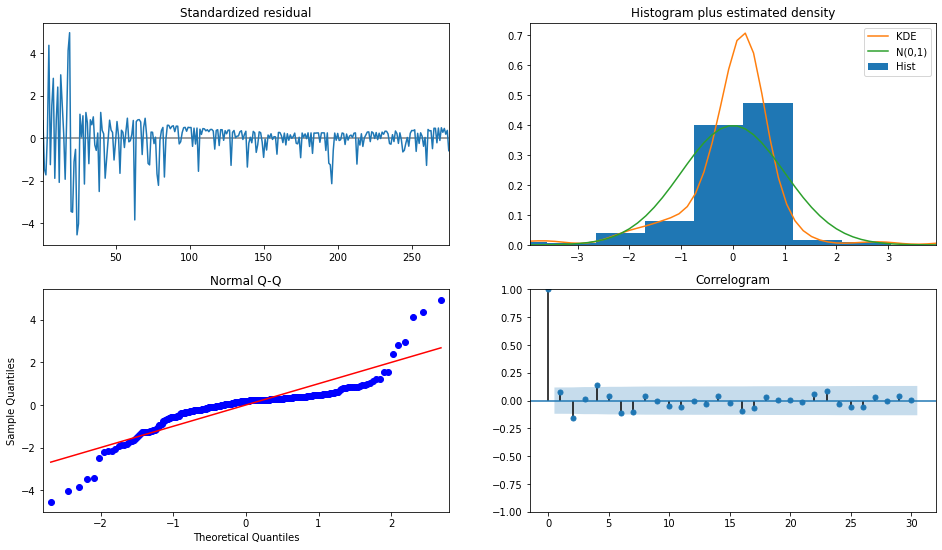

In [38]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

In [39]:
time_df

,Date,Loss,Scale,Shape,Location
0,2012-03-11,1.257435,71.432007,228.756956,-71.028549
1,2012-03-18,0.501901,71.432007,228.756956,-71.028549
2,2012-03-25,0.105748,71.432007,228.756956,-71.028549
3,2012-04-01,0.269582,71.432007,228.756956,-71.028549
4,2012-04-08,0.680169,71.432007,228.756956,-71.028549
...,...,...,...,...,...
522,2022-03-13,0.922122,NaN,NaN,-71.028549
523,2022-03-20,0.324588,NaN,NaN,-71.028549
524,2022-03-27,0.406908,NaN,NaN,-71.028549
525,2022-04-03,0.833483,NaN,NaN,-71.028549


## Changed how the df updates new shape and scale params when walking forward test set and cvar

In [64]:
new_df=pd.DataFrame()
new_df['date']=time_df['Date']
new_df['Loss']=time_df['Loss']
new_df['Scale']=time_df['Scale']
new_df['Shape']=time_df['Shape']
new_df['Location']=time_df['Location']

cvar1=pd.Series([])
cvar2=pd.Series([])
cvar3=pd.Series([])

counter = 0

for x,row in new_df.iterrows():
    if not np.isnan(row['Shape']) and not np.isnan(row['Scale']) :
        counter=counter+1
        cvar1=cvar1.append(pd.Series([np.nan],index=[x]))
        cvar2=cvar2.append(pd.Series([np.nan],index=[x]))
        cvar3=cvar3.append(pd.Series([np.nan],index=[x]))
        continue
    
    row['Shape']=np.exp(shape_params[0]+shape_params[1]*np.log(new_df['Shape'][counter-1])+shape_params[2]*np.exp(-new_df['Loss'][counter-1]) )# walk forward from our eqns
    row['Scale']=np.exp(scale_params[0]+scale_params[1]*np.log(new_df['Scale'][counter-1])+scale_params[2]*np.exp(-new_df['Loss'][counter-1]) )# walk forward 
 
    # empirical cvars for each fitted period outside of train set #1 
    cvar1=cvar1.append(pd.Series([1-conditional_value_at_risk(new_df['Loss'][:counter],0.90)],index=[x]))
    cvar2=cvar2.append(pd.Series([1-conditional_value_at_risk(new_df['Loss'][:counter],0.95)],index=[x]))
    cvar3=cvar3.append(pd.Series([1-conditional_value_at_risk(new_df['Loss'][:counter],0.99)],index=[x]))
    new_df.iloc[x]=row
    counter=counter+1
new_df['cvar_0.90']=cvar1
new_df['cvar_0.95']=cvar2
new_df['cvar_0.99']=cvar3
    
new_df

<ipython-input-64-9a5eddf61c14>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cvar1=pd.Series([])
<ipython-input-64-9a5eddf61c14>:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cvar2=pd.Series([])
<ipython-input-64-9a5eddf61c14>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cvar3=pd.Series([])


,date,Loss,Scale,Shape,Location,cvar_0.90,cvar_0.95,cvar_0.99
0,2012-03-11,1.257435,71.432007,228.756956,-71.028549,NaN,NaN,NaN
1,2012-03-18,0.501901,71.432007,228.756956,-71.028549,NaN,NaN,NaN
2,2012-03-25,0.105748,71.432007,228.756956,-71.028549,NaN,NaN,NaN
3,2012-04-01,0.269582,71.432007,228.756956,-71.028549,NaN,NaN,NaN
4,2012-04-08,0.680169,71.432007,228.756956,-71.028549,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
522,2022-03-13,0.922122,71.398053,256.673645,-71.028549,0.557539,0.526365,0.489020
523,2022-03-20,0.324588,71.398959,256.610238,-71.028549,0.556518,0.525461,0.488225
524,2022-03-27,0.406908,71.398600,256.621840,-71.028549,0.556771,0.525762,0.488587
525,2022-04-03,0.833483,71.398464,256.620259,-71.028549,0.556848,0.525898,0.488788


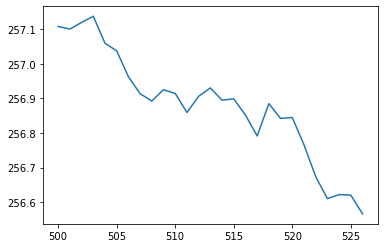

In [65]:
plt.plot(new_df['Shape'][500:])


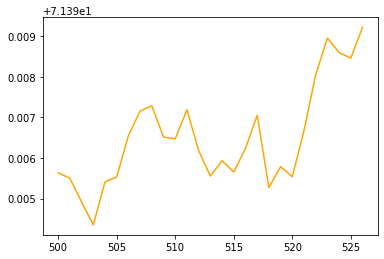

In [66]:
plt.plot(new_df['Scale'][500:],color='orange')

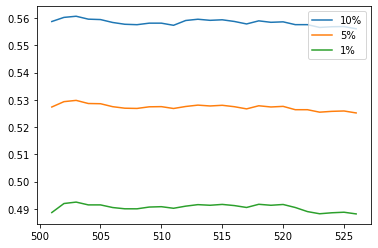

In [67]:
plt.plot(new_df['cvar_0.90'],label='10%')
plt.plot(new_df['cvar_0.95'],label='5%')
plt.plot(new_df['cvar_0.99'],label='1%')
plt.legend()

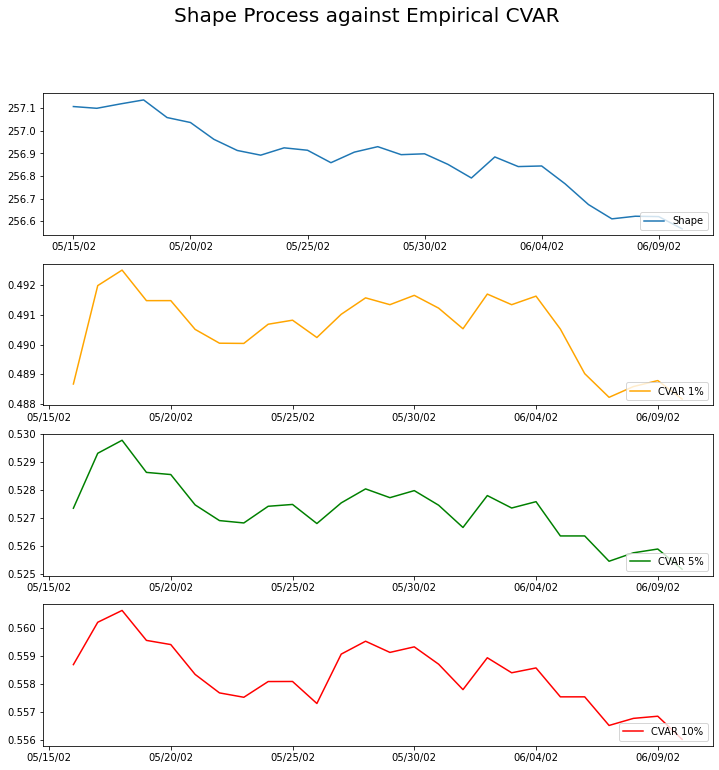

In [68]:
fig,ax = plt.subplots(4,1,figsize=(12,12))

fig.suptitle("Shape Process against Empirical CVAR",fontsize=20)

ax[0].plot(new_df['Shape'][500:], label='Shape')
ax[1].plot(new_df['cvar_0.99'][500:], label='CVAR 1%',color='orange') 
ax[2].plot(new_df['cvar_0.95'][500:], label='CVAR 5%',color='green') 
ax[3].plot(new_df['cvar_0.90'][500:], label='CVAR 10%',color='red') 
ax[0].legend(loc='lower right')
ax[1].legend(loc='lower right')
ax[2].legend(loc='lower right')
ax[3].legend(loc='lower right')
ax[0].xaxis.set_major_formatter(DateFormatter("%D"))
ax[1].xaxis.set_major_formatter(DateFormatter("%D"))
ax[2].xaxis.set_major_formatter(DateFormatter("%D"))
ax[3].xaxis.set_major_formatter(DateFormatter("%D"))

In [71]:
print(np.corrcoef(new_df['Shape'][501:],new_df['cvar_0.90'][501:]))
print(np.corrcoef(new_df['Shape'][501:],new_df['cvar_0.95'][501:]))
print(np.corrcoef(new_df['Shape'][501:],new_df['cvar_0.99'][501:]))

[[1.         0.86215999]
 [0.86215999 1.        ]]
[[1.         0.90777341]
 [0.90777341 1.        ]]
[[1.         0.69756739]
 [0.69756739 1.        ]]
